In [ ]:
import pandas as pd
import numpy as np
import math

In [ ]:
!pip install requests

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Dataset.xlsx to Dataset.xlsx


In [ ]:
excel_file = list(uploaded.keys())[0]
print(f"\n File uploaded successfully: {excel_file}")

# Step 3. Show all sheet names
xls = pd.ExcelFile(excel_file)
print("\n Available sheet names in the workbook:")
for name in xls.sheet_names:
    print(" -", name)


 File uploaded successfully: Dataset.xlsx

 Available sheet names in the workbook:
 - auditors
 - audit_capabilities
 - certifications 
 - tools_used
 - past_audit_statistics 
 - team_profile
 - project_highlights


In [ ]:

# Define expected sheet names and their possible matches
expected_sheets = [
    "auditors",
    "audit_capabilities",
    "certifications",
    "tools_used",
    "past_audit_statistics",
    "team_profile",
    "project_highlights"
]

# Helper function to find closest matching sheet name
def find_best_match(name, available):
    for s in available:
        if name.lower().replace("_", "").replace(" ", "") in s.lower().replace("_", "").replace(" ", ""):
            return s
    return None

# Load sheets dynamically
loaded_data = {}
for sheet in expected_sheets:
    match = find_best_match(sheet, xls.sheet_names)
    if match:
        print(f" Loading sheet: {match} (matched with '{sheet}')")
        loaded_data[sheet] = pd.read_excel(excel_file, sheet_name=match)
    else:
        print(f" Sheet '{sheet}' not found in Excel file.")

# Example: access a specific sheet’s dataframe
auditors = loaded_data.get("auditors")

 Loading sheet: auditors (matched with 'auditors')
 Loading sheet: audit_capabilities (matched with 'audit_capabilities')
 Loading sheet: certifications  (matched with 'certifications')
 Loading sheet: tools_used (matched with 'tools_used')
 Loading sheet: past_audit_statistics  (matched with 'past_audit_statistics')
 Loading sheet: team_profile (matched with 'team_profile')
 Loading sheet: project_highlights (matched with 'project_highlights')


In [ ]:
# === STEP 2: Load the 'auditors' sheet ===
auditors_df = pd.read_excel(excel_file, sheet_name='auditors')

# === STEP 3: Clean and normalize column names (optional but useful) ===
auditors_df.columns = auditors_df.columns.str.strip().str.lower().str.replace(' ', '_')

# === STEP 4: Display to confirm structure ===
print(" Master Sheet Loaded: auditors")
display(auditors_df.head())

# === STEP 5: Build a lookup dictionary (optional helper) ===
auditor_lookup = dict(zip(auditors_df['auditor_id'], auditors_df['name']))

print("\n Auditor Lookup Dictionary (for reference):")
for k, v in list(auditor_lookup.items())[:10]:
    print(f"{k}: {v}")

# === STEP 6: Define a helper to load other sheets using this mapping ===
def load_sheet(sheet_name):
    """Loads a sheet and merges it with auditor info if auditor_id exists."""
    try:
        df = pd.read_excel(excel_file, sheet_name=sheet_name)
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
        if 'auditor_id' in df.columns:
            df = df.merge(auditors_df[['auditor_id', 'name']], on='auditor_id', how='left')
        print(f" Loaded sheet: {sheet_name} ({len(df)} rows)")
        return df
    except Exception as e:
        print(f" Could not load sheet '{sheet_name}': {e}")

 Master Sheet Loaded: auditors


,auditor_id,name,locations,start_year,outsourcing,foreign_tie_up,overseas_offices
0,A001,AAA Technologies Pvt Ltd,"[Mumbai, Delhi, Bangalore, Lucknow, Chennai, P...",2000,No,No,NaN
1,A002,Bharat Electronics Limited,"[Bangalore, Ghaziabad, Pune, Machlipatnam, Che...",2015,No,No,"[USA, Singapore, Sri Lanka, Oman, Myanmar, Vie..."
2,A003,CyRAAC Services Private Limited,"[Bengaluru, Karnataka]",2017,No,No,[Dubai]
3,A004,Madhya Pradesh State Electronics Development C...,[Madhya Pradesh],2013,No,No,NaN
4,A005,Maverick Quality Advisory Services Private Lim...,[Ghaziabad],2005,No,No,NaN



 Auditor Lookup Dictionary (for reference):
A001: AAA Technologies Pvt Ltd
A002: Bharat Electronics Limited
A003: CyRAAC Services Private Limited
A004: Madhya Pradesh State Electronics Development Corporation (MPSEDC)
A005: Maverick Quality Advisory Services Private Limited
A006: RSM Astute Consulting Pvt. Ltd.
A007: Mirox Cyber Security & Technology Pvt Ltd
A008: AQM Technologies Pvt Ltd.
A009: Centre for Development of Advanced Computing (C - DAC)
A010: Crossbow Labs LLP


In [ ]:
# ===================================
# STEP 2: Q_exp (Audit Experience)
# ===================================

def compute_Q_exp(stats_df):
    # --- Clean and ensure numeric ---
    for col in ["govt_audits", "psu_audits", "private_audits"]:
        stats_df[col] = pd.to_numeric(stats_df[col], errors="coerce").fillna(0)

    # --- Weighted audit experience ---
    stats_df["X_weighted"] = (
        1.0 * stats_df["govt_audits"] +
        0.8 * stats_df["psu_audits"] +
        0.6 * stats_df["private_audits"]
    )

    # --- Normalization (0–1 scale) ---
    Xmin, Xmax = stats_df["X_weighted"].min(), stats_df["X_weighted"].max()
    if Xmax == Xmin:
        stats_df["Q_exp"] = 1.0  # Avoid division by zero if all are same
    else:
        stats_df["Q_exp"] = (stats_df["X_weighted"] - Xmin) / (Xmax - Xmin)

    return stats_df[["auditor_id", "Q_exp", "X_weighted"]]

# === STEP 1: Load the sheet ===
stats = loaded_data.get("past_audit_statistics")

# === STEP 2: Compute the experience score ===
Q_exp = compute_Q_exp(stats)

# === STEP 3: (Optional) Merge with auditor names for readability ===
Q_exp = Q_exp.merge(auditors_df[["auditor_id", "name"]], on="auditor_id", how="left")

# === Display results ===
print(" Computed Audit Experience (Q_exp):")
display(Q_exp)

# ===================================

 Computed Audit Experience (Q_exp):


,auditor_id,Q_exp,X_weighted,name
0,A001,1.000000,1180.0,AAA Technologies Pvt Ltd
1,A002,0.000000,21.6,Bharat Electronics Limited
2,A003,0.085808,121.0,CyRAAC Services Private Limited
3,A004,0.082700,117.4,Madhya Pradesh State Electronics Development C...
4,A005,0.567507,679.0,Maverick Quality Advisory Services Private Lim...
5,A006,0.014675,38.6,RSM Astute Consulting Pvt. Ltd.
6,A007,0.087189,122.6,Mirox Cyber Security & Technology Pvt Ltd
7,A008,0.001727,23.6,AQM Technologies Pvt Ltd.
8,A009,0.262949,326.2,Centre for Development of Advanced Computing (...
9,A010,0.048688,78.0,Crossbow Labs LLP


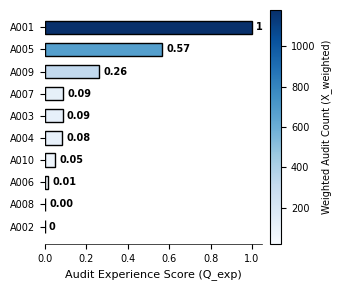

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Use Google Colab default font (DejaVu Sans) ---
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['pdf.fonttype'] = 42  # Vector text
plt.rcParams['ps.fonttype'] = 42

# Assume Q_exp dataframe exists with columns: ["auditor_id", "Q_exp", "X_weighted"]
Q_exp_sorted = Q_exp.sort_values('Q_exp', ascending=True).reset_index(drop=True)

# Normalize X_weighted for color mapping
norm = plt.Normalize(Q_exp_sorted['X_weighted'].min(), Q_exp_sorted['X_weighted'].max())
colors = plt.cm.Blues(norm(Q_exp_sorted['X_weighted']))

# --- Dynamic figure height based on number of auditors ---
n_auditors = len(Q_exp_sorted)
fig_height = max(3, n_auditors * 0.3)  # 0.3 inch per auditor, min 3 inches
fig, ax = plt.subplots(figsize=(3.5, fig_height))  # single-column IEEE/NLP width

# Horizontal bars with edge color
bars = ax.barh(Q_exp_sorted['auditor_id'], Q_exp_sorted['Q_exp'],
               color=colors, edgecolor='black', height=0.6)

# Add annotations with padding
padding = 0.02 * (Q_exp_sorted['Q_exp'].max() - Q_exp_sorted['Q_exp'].min())
for bar in bars:
    width = bar.get_width()
    x_pos = width + padding
    # Format: integer without .00, else 2 decimals
    if width.is_integer():
        label = f'{int(width)}'
    else:
        label = f'{width:.2f}'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2,
            label, va='center', fontsize=7, fontweight='bold')

# Axis label
ax.set_xlabel('Audit Experience Score (Q_exp)', fontsize=8)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=7)

# Minimalist styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)

# Colorbar for X_weighted
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.03)
cbar.set_label('Weighted Audit Count (X_weighted)', fontsize=7)
cbar.ax.tick_params(labelsize=7)

# Layout adjustment
plt.tight_layout()

# Save vector PDF for sharp text
plt.savefig('Qexp_Colab_DefaultFont.pdf', format='pdf')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# ===================================
# STEP 0: Load your employee-level auditor data
# ===================================
team_profile_df = loaded_data.get("team_profile")

if team_profile_df is None:
    raise ValueError("Error: 'team_profile' sheet not found in loaded_data.")

# === Clean and normalize column names ===
team_profile_df.columns = team_profile_df.columns.str.strip().str.lower().str.replace(' ', '_')

# Ensure 'experience_years' is numeric
team_profile_df['experience_years'] = pd.to_numeric(team_profile_df['experience_years'], errors='coerce').fillna(0)

# Convert 'certs' column to list
def parse_certs(certs_value):
    if isinstance(certs_value, str):
        return [c.strip() for c in certs_value.split(',') if c.strip()]
    elif isinstance(certs_value, list):
        return certs_value
    else:
        return []  # Treat NaN or other types as empty list

team_profile_df['certs'] = team_profile_df['certs'].apply(parse_certs)

# ===================================
# STEP 1: Certification Weights
# ===================================
cert_weights_upper = {k.upper(): v for k, v in {
    "CISSP": 1.0, "CISA": 1.0, "ISO27001 LA": 1.0, "BS7799 / ISO27001 LA": 1.0, "CISM": 1.0,
    # Mid-tier
    "CEH": 0.6, "CCNSP": 0.6, "CHFI": 0.6, "CSA": 0.6, "ACE": 0.6,
    "OSCP": 0.6, "PNPT": 0.6, "eJPT": 0.6, "eMAPT": 0.6, "CRTP": 0.6, "eWPT": 0.6,
    "DISAs / ISAs": 0.6, "DISA / ISA": 0.6,
    "M.Tech (Information Security)": 0.6,
    "M.Tech (Cyber Security)": 0.6,
    "M.Tech (Cyber Law & Information Security)": 0.6,
    "NPT": 0.6,
    # Low-tier / Other
    "Other": 0.4,
    "Other information security qualification": 0.4
}.items()}

# ===================================
# STEP 2: Compute weighted experience per employee
# ===================================
def weighted_experience(row):
    Y = row["experience_years"]
    certs = row["certs"]
    total_cert_weight = 0
    for c in certs:
        w = cert_weights_upper.get(c.upper(), 0.4)  # Unknown mapped to 0.4
        total_cert_weight += w
    return Y * (1 + total_cert_weight)

team_profile_df["weighted_exp"] = team_profile_df.apply(weighted_experience, axis=1)

# ===================================
# STEP 3: Compute robust team stability per auditor (Q_RET_robust)
# ===================================
Qret_list = []
for aud_id, group in team_profile_df.groupby("auditor_id"):
    if not group["weighted_exp"].empty:
        wexp = group["weighted_exp"].values
        N = len(wexp)  # team size
        median_exp = np.median(wexp)
        mad_exp = np.median(np.abs(wexp - median_exp))
        # Robust formula including team size
        Q_RET_robust = (median_exp**2 * N) / (median_exp + mad_exp + 1e-9)
        Qret_list.append({
            "auditor_id": aud_id,
            "team_size": N,
            "median_weighted_exp": median_exp,
            "MAD_weighted_exp": mad_exp,
            "Q_RET_robust": Q_RET_robust
        })

Qret_df = pd.DataFrame(Qret_list)

# ===================================
# STEP 4: Normalize Q_RET_robust to 0-1 (Q_ret)
# ===================================
if not Qret_df.empty:
    Qmin, Qmax = Qret_df["Q_RET_robust"].min(), Qret_df["Q_RET_robust"].max()
    Qret_df["Q_ret"] = 1.0 if Qmax == Qmin else (Qret_df["Q_RET_robust"] - Qmin) / (Qmax - Qmin)
else:
    print("No data to compute Q_ret scores.")

# ===================================
# STEP 5: Display final robust team stability scores
# ===================================
print("Robust Team Stability Score (Q_ret) per Auditor including certifications and team size:")
display(Qret_df)


Robust Team Stability Score (Q_ret) per Auditor including certifications and team size:


,auditor_id,team_size,median_weighted_exp,MAD_weighted_exp,Q_RET_robust,Q_ret
0,A001,88,4.80,2.10,293.843478,0.849276
1,A002,28,8.40,2.90,174.838938,0.462345
2,A003,20,3.60,2.20,44.689655,0.039178
3,A004,6,38.00,24.20,139.292604,0.346770
4,A005,32,2.80,1.40,59.733333,0.088091
5,A006,51,6.30,3.50,206.550000,0.565450
6,A007,10,5.45,3.65,32.640110,0.000000
7,A008,37,6.44,2.30,175.574737,0.464738
8,A009,135,4.20,2.80,340.200000,1.000000
9,A010,14,9.50,5.61,83.620119,0.165756


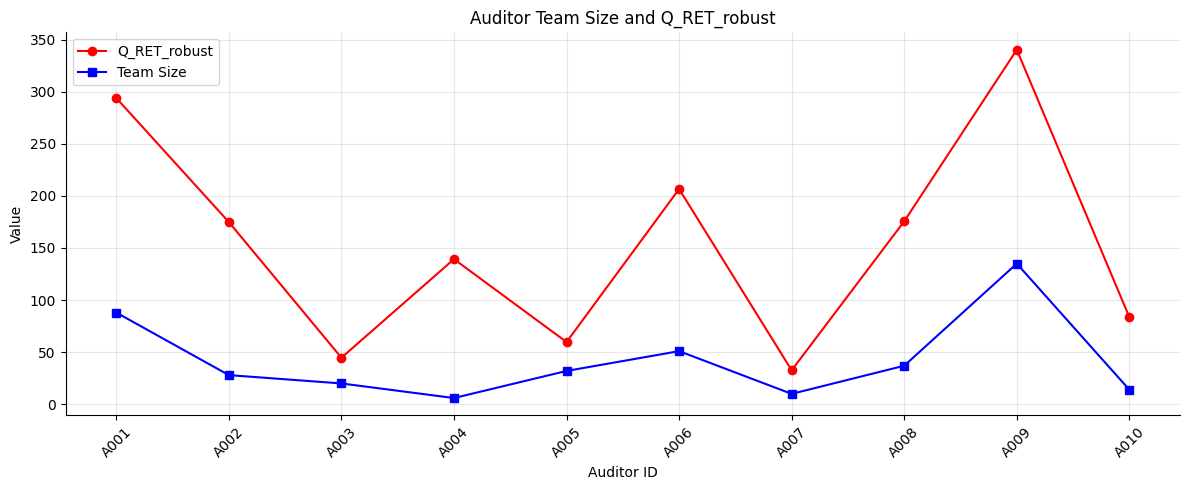

In [ ]:
from matplotlib import pyplot as plt

# Make sure auditor_id is sorted for consistent plotting
Qret_df_sorted = Qret_df.sort_values('auditor_id')

plt.figure(figsize=(12,5))

# Plot Q_RET_robust
plt.plot(Qret_df_sorted['auditor_id'], Qret_df_sorted['Q_RET_robust'], marker='o', color='red', label='Q_RET_robust')

# Plot team_size
plt.plot(Qret_df_sorted['auditor_id'], Qret_df_sorted['team_size'], marker='s', color='blue', label='Team Size')

# Labels and title
plt.xlabel('Auditor ID')
plt.ylabel('Value')
plt.title('Auditor Team Size and Q_RET_robust')
plt.xticks(rotation=45)
plt.legend()

# Remove top/right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
def compute_Q_tools(sheet_name="tools_used", lambda_div=0.7):
    import math
    import pandas as pd

    tools_df = load_sheet(sheet_name)
    if tools_df is None or tools_df.empty:
        print(f"⚠️ No data found in sheet '{sheet_name}'")
        return pd.DataFrame()

    # Quality weights
    w_dict = {"Freeware": 0.6, "Proprietary": 0.8, "Commercial": 1.0}

    def entropy(series):
        counts = series.value_counts()
        total = counts.sum()
        probs = counts / total
        H = -sum(p * math.log2(p) for p in probs if p > 0)
        return H / math.log2(3)  # normalize for 3 categories

    Q_list = []
    for aid, group in tools_df.groupby("auditor_id"):
        tool_types = group["tool_type"]
        Q_div = entropy(tool_types)
        Q_qual = sum([w_dict.get(t, 0.6) for t in tool_types]) / len(tool_types)
        Q_tools = lambda_div * Q_div + (1 - lambda_div) * Q_qual
        Q_list.append({
            "auditor_id": aid,
            "Q_div": round(Q_div, 3),
            "Q_qual": round(Q_qual, 3),
            "Q_tools": round(Q_tools, 3)
        })

    Q_df = pd.DataFrame(Q_list)

    # Works in both notebooks and scripts
    print("Computed Tool Diversity Scores:")
    print(Q_df.to_string(index=False))

    return Q_df

# Call the function
Q_tools = compute_Q_tools("tools_used")



 Loaded sheet: tools_used (548 rows)
Computed Tool Diversity Scores:
auditor_id  Q_div  Q_qual  Q_tools
      A001  0.548   0.662    0.582
      A002  0.550   0.680    0.589
      A003  0.527   0.671    0.570
      A004  0.456   0.648    0.514
      A005  0.327   0.634    0.419
      A006  0.691   0.691    0.691
      A007  0.069   0.606    0.230
      A008  0.631   0.700    0.651
      A009  0.746   0.768    0.753
      A010  0.563   0.665    0.594


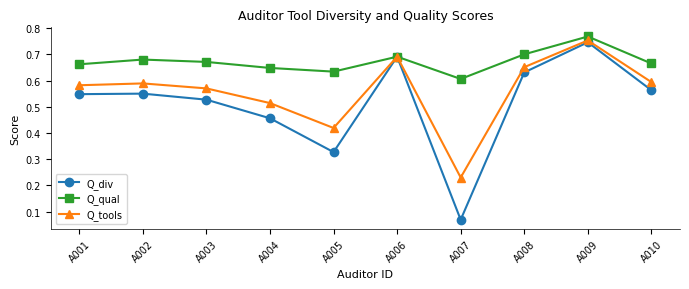

In [ ]:
import matplotlib.pyplot as plt

# --- Use Google Colab default font ---
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Sort by auditor_id for consistent x-axis
Q_tools_sorted = Q_tools.sort_values('auditor_id').reset_index(drop=True)

# Dynamic figure size
n_auditors = len(Q_tools_sorted)
fig_height = max(3, n_auditors * 0.25)
fig, ax = plt.subplots(figsize=(7, fig_height))

# Plot Q_div, Q_qual, Q_tools
ax.plot(Q_tools_sorted['auditor_id'], Q_tools_sorted['Q_div'], marker='o', color='tab:blue', label='Q_div')
ax.plot(Q_tools_sorted['auditor_id'], Q_tools_sorted['Q_qual'], marker='s', color='tab:green', label='Q_qual')
ax.plot(Q_tools_sorted['auditor_id'], Q_tools_sorted['Q_tools'], marker='^', color='tab:orange', label='Q_tools')

# Labels and title
ax.set_xlabel('Auditor ID', fontsize=8)
ax.set_ylabel('Score', fontsize=8)
ax.set_title('Auditor Tool Diversity and Quality Scores', fontsize=9)

# Tick formatting
ax.tick_params(axis='x', rotation=45, labelsize=7)
ax.tick_params(axis='y', labelsize=7)

# Minimalist styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Legend
ax.legend(fontsize=7)

# Layout adjustment
plt.tight_layout()

# Save vector PDF
plt.savefig('Qtools_Diversity_ColabFont.pdf', format='pdf')
plt.show()


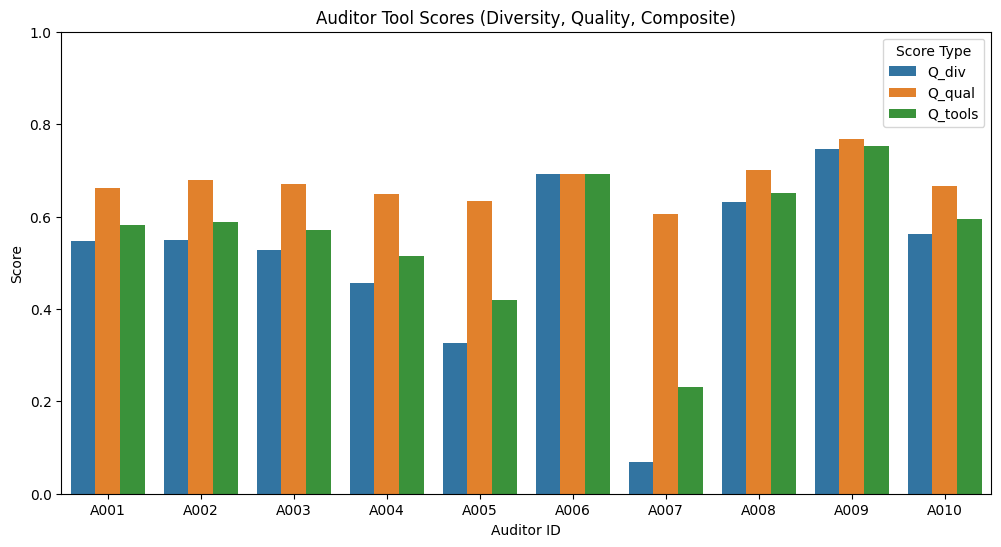

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,6))
Q_melted = Q_tools_sorted.melt(id_vars='auditor_id', value_vars=['Q_div', 'Q_qual', 'Q_tools'],
                               var_name='Score Type', value_name='Value')
sns.barplot(data=Q_melted, x='auditor_id', y='Value', hue='Score Type')
plt.title('Auditor Tool Scores (Diversity, Quality, Composite)')
plt.xlabel('Auditor ID')
plt.ylabel('Score')
plt.ylim(0,1)
plt.legend(title='Score Type')
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# ===================================
# STEP 6: Q_scope (Activity-Weighted Scope Fitness) - Robust Version
# ===================================

def compute_Q_scope(sheet_name="audit_capabilities"):
    """
    Computes Scope Fitness Score (Q_scope) for auditors,
    weighting by actual audits performed in the last year
    and proportion of active vs declared scopes.
    """
    cap_df = loaded_data.get(sheet_name)
    if cap_df is None:
        print(f"Sheet '{sheet_name}' not found.")
        return pd.DataFrame({"auditor_id": [], "Q_scope": []})

    # Clean column names
    cap_df.columns = cap_df.columns.str.strip().str.lower()

    # Required columns
    required_cols = {"auditor_id", "scope_type", "audits_last_year"}
    if not required_cols.issubset(cap_df.columns):
        missing = required_cols - set(cap_df.columns)
        print(f"Missing columns: {missing}")
        return pd.DataFrame({"auditor_id": [], "Q_scope": []})

    # Convert audits_last_year to numeric; ignore non-numeric entries
    cap_df["audits_last_year"] = pd.to_numeric(cap_df["audits_last_year"], errors="coerce")

    Qscope_list = []

    for aid, group in cap_df.groupby("auditor_id"):
        declared_scopes = group["scope_type"].unique()
        n_declared = len(declared_scopes)

        # Only consider active scopes with audits > 0
        active_group = group[group["audits_last_year"] > 0].copy()

        if not active_group.empty:
            active_group["w"] = np.log1p(active_group["audits_last_year"])
            weighted_sum = active_group["w"].sum()
        else:
            weighted_sum = 0.0

        # Proportionally weight by number of declared scopes
        Q_SCOPE_raw = weighted_sum / n_declared if n_declared > 0 else 0.0
        Qscope_list.append({"auditor_id": aid, "Q_scope_raw": Q_SCOPE_raw})

    df = pd.DataFrame(Qscope_list)

    # Normalize across auditors
    if not df.empty:
        Qmin, Qmax = df["Q_scope_raw"].min(), df["Q_scope_raw"].max()
        if Qmax == Qmin:
            df["Q_scope"] = 1.0 if Qmax > 0 else 0.0
        else:
            df["Q_scope"] = (df["Q_scope_raw"] - Qmin) / (Qmax - Qmin)
    else:
        df["Q_scope"] = 0.0

    return df[["auditor_id", "Q_scope"]]

# === Compute Q_scope ===
Q_scope = compute_Q_scope("audit_capabilities")
print("Computed Activity-Weighted Scope Fitness (Q_scope):")
display(Q_scope)


Computed Activity-Weighted Scope Fitness (Q_scope):


,auditor_id,Q_scope
0,A001,0.400835
1,A002,0.000000
2,A003,0.813283
3,A004,0.193813
4,A005,0.551006
5,A006,0.186192
6,A007,0.334179
7,A008,0.193618
8,A009,0.565801
9,A010,1.000000


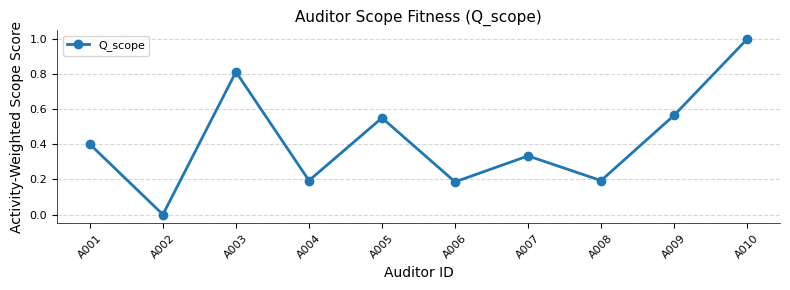

In [ ]:
import matplotlib.pyplot as plt

# Ensure auditor_id is sorted or categorical order is preserved
Q_scope_sorted = Q_scope.sort_values('auditor_id').reset_index(drop=True)

# Dynamic figure size based on number of auditors
n_auditors = len(Q_scope_sorted)
fig_height = max(3, n_auditors * 0.25)  # 0.25 inch per auditor

fig, ax = plt.subplots(figsize=(8, fig_height))

# Plot Q_scope line
ax.plot(Q_scope_sorted['auditor_id'], Q_scope_sorted['Q_scope'],
        marker='o', color='tab:blue', linewidth=2, label='Q_scope')

# Labels and title
ax.set_xlabel('Auditor ID', fontsize=10)
ax.set_ylabel('Activity-Weighted Scope Score', fontsize=10)
ax.set_title('Auditor Scope Fitness (Q_scope)', fontsize=11)

# Tick formatting
ax.tick_params(axis='x', rotation=45, labelsize=8)
ax.tick_params(axis='y', labelsize=8)

# Minimalist styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Optional: add grid
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Legend
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# ===================================
# STEP 7: Q_proj (High-Impact Projects)
# ===================================

import math
import pandas as pd

def compute_Q_proj(project_df):
    weights = {"Government": 1.0, "PSU": 0.8, "Private": 0.6}

    # Compute weighted score for each project
    def score_project(row):
        try:
            value = float(row["project_value_cr"])
        except:
            value = 0.0
        return math.log(1 + value) * weights.get(row["sector"], 0.6)

    project_df["s"] = project_df.apply(score_project, axis=1)

    # Average per auditor
    proj_score = project_df.groupby("auditor_id")["s"].mean().reset_index(name="Q_proj_raw")

    # Normalization
    Pmin, Pmax = proj_score["Q_proj_raw"].min(), proj_score["Q_proj_raw"].max()
    if Pmax == Pmin:
        proj_score["Q_proj"] = 1.0
    else:
        proj_score["Q_proj"] = (proj_score["Q_proj_raw"] - Pmin) / (Pmax - Pmin)


    # Print results
    print("Computed High-Impact Project Score (Q_proj):")
    print(proj_score[["auditor_id", "Q_proj"]])

    return proj_score[["auditor_id", "Q_proj"]]

# Example call
projects = loaded_data.get("project_highlights")
Q_proj = compute_Q_proj(projects)

Computed High-Impact Project Score (Q_proj):
  auditor_id    Q_proj
0       A001  0.984318
1       A002  0.000000
2       A003  0.000000
3       A004  0.000000
4       A005  0.301110
5       A006  0.228676
6       A007  0.000000
7       A008  1.000000
8       A009  0.801081
9       A010  0.000000


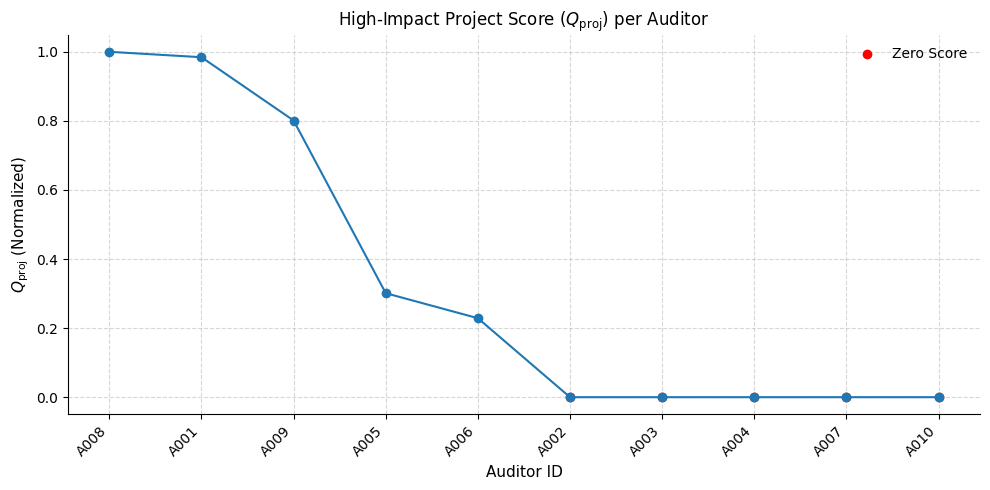

In [ ]:
import matplotlib.pyplot as plt

# Sort auditors by Q_proj for better readability
Q_proj_sorted = Q_proj.sort_values("Q_proj", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 5))
plt.plot(Q_proj_sorted["auditor_id"], Q_proj_sorted["Q_proj"], marker='o', linestyle='-', color='tab:blue')

# Highlight auditors with zero score
zero_scores = Q_proj_sorted[Q_proj_sorted["Q_proj"] == 0]
plt.scatter(zero_scores["auditor_id"], zero_scores["Q_proj"], color='red', label='Zero Score')

# Labels and styling
plt.title("High-Impact Project Score ($Q_{\\text{proj}}$) per Auditor", fontsize=12)
plt.xlabel("Auditor ID", fontsize=11)
plt.ylabel("$Q_{\\text{proj}}$ (Normalized)", fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(frameon=False)
plt.gca().spines[['top', 'right']].set_visible(False)

# Adjust layout and show
plt.tight_layout()
plt.show()


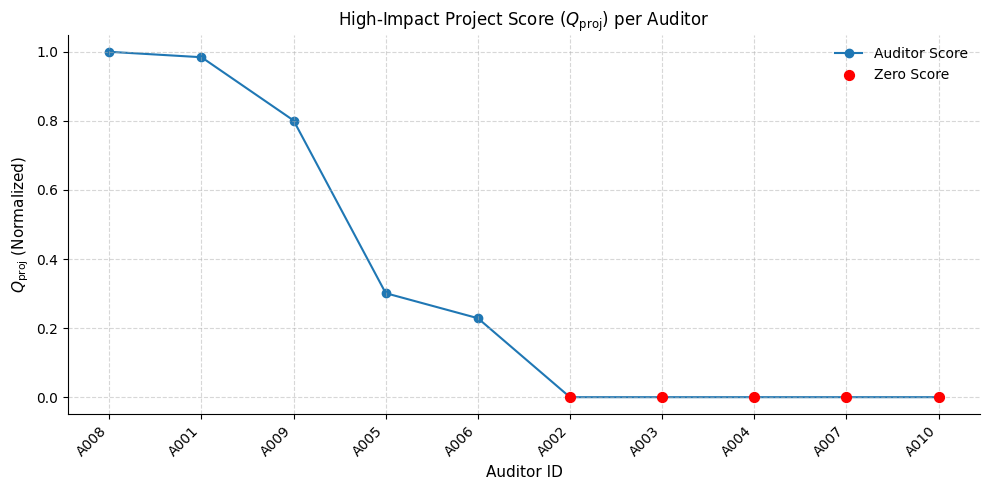

In [ ]:
import matplotlib.pyplot as plt

# Sort auditors by Q_proj
Q_proj_sorted = Q_proj.sort_values("Q_proj", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 5))

# Main line plot (drawn below)
plt.plot(
    Q_proj_sorted["auditor_id"],
    Q_proj_sorted["Q_proj"],
    marker='o',
    linestyle='-',
    color='tab:blue',
    label='Auditor Score',
    zorder=1  # Draw this first
)

# Highlight zero scores (drawn on top)
zero_scores = Q_proj_sorted[Q_proj_sorted["Q_proj"] == 0]
plt.scatter(
    zero_scores["auditor_id"],
    zero_scores["Q_proj"],
    color='red',
    s=50,
    label='Zero Score',
    zorder=2  # Draw on top
)

# Labels and styling
plt.title("High-Impact Project Score ($Q_{\\text{proj}}$) per Auditor", fontsize=12)
plt.xlabel("Auditor ID", fontsize=11)
plt.ylabel("$Q_{\\text{proj}}$ (Normalized)", fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(frameon=False)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# ===================================
# STEP 3: Q_cert (Team Certification)
# ===================================

def compute_Q_cert(sheet_name="certifications"):
    # --- STEP 1: Load the sheet ---
    certs_df = loaded_data.get(sheet_name)

    # --- STEP 2: Define weights for certifications ---
    cert_weights = {
        "CISSP": 1.0,
        "CISA": 1.0,
        "ISO27001 LA": 1.0,
        "BS7799 / ISO27001 LA": 1.0,
        "CISM": 1.0,
        # Mid-tier certifications
        "CEH": 0.6,
        "CCNSP": 0.6,
        "CHFI": 0.6,
        "CSA": 0.6,
        "ACE": 0.6,
        "OSCP": 0.6,
        "PNPT": 0.6,
        "eJPT": 0.6,
        "eMAPT": 0.6,
        "CRTP": 0.6,
        "eWPT": 0.6,
        "DISAs / ISAs": 0.6,
        "DISA / ISA": 0.6,
        "M.Tech (Information Security)": 0.6,
        "M.Tech (Cyber Security)": 0.6,
        "M.Tech (Cyber Law & Information Security)": 0.6,
        "NPT": 0.6,
        "Other": 0.4,
        "Other information security qualification": 0.4
    }

    # --- STEP 3: Clean data ---
    certs_df["num_people"] = pd.to_numeric(certs_df["num_people"], errors="coerce").fillna(0)
    certs_df["certification"] = certs_df["certification"].str.strip()

    # --- STEP 4: Compute weighted score ---
    certs_df["weight"] = certs_df["certification"].map(cert_weights).fillna(0.5)
    certs_df["weighted"] = certs_df["weight"] * certs_df["num_people"]

    cert_sum = certs_df.groupby("auditor_id")["weighted"].sum().reset_index(name="CertficateScore_raw")

    # --- STEP 5: Normalize 0-1 ---
    Cmin, Cmax = cert_sum["CertficateScore_raw"].min(), cert_sum["CertficateScore_raw"].max()
    if Cmax == Cmin:
        cert_sum["Q_cert"] = 1.0
    else:
        cert_sum["Q_cert"] = (cert_sum["CertficateScore_raw"] - Cmin) / (Cmax - Cmin)

    # --- STEP 6: Merge with auditor names ---
    cert_sum = cert_sum.merge(auditors_df[["auditor_id", "name"]], on="auditor_id", how="left")

    return cert_sum[["auditor_id", "name", "Q_cert", "CertficateScore_raw"]]

# === Compute Q_cert ===
Q_cert = compute_Q_cert()

# === Display result ===
print("Computed Team Certification Score (Q_cert):")
display(Q_cert)

Computed Team Certification Score (Q_cert):


,auditor_id,name,Q_cert,CertficateScore_raw
0,A001,AAA Technologies Pvt Ltd,0.759834,86.8
1,A002,Bharat Electronics Limited,0.184265,31.2
2,A003,CyRAAC Services Private Limited,0.065217,19.7
3,A004,Madhya Pradesh State Electronics Development C...,0.000000,13.4
4,A005,Maverick Quality Advisory Services Private Lim...,0.189441,31.7
5,A006,RSM Astute Consulting Pvt. Ltd.,0.273292,39.8
6,A007,Mirox Cyber Security & Technology Pvt Ltd,0.018634,15.2
7,A008,AQM Technologies Pvt Ltd.,0.130435,26.0
8,A009,Centre for Development of Advanced Computing (...,1.000000,110.0
9,A010,Crossbow Labs LLP,0.023810,15.7


/tmp/ipython-input-1966599802.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(Q_cert_sorted["auditor_id"], rotation=45, ha='right')


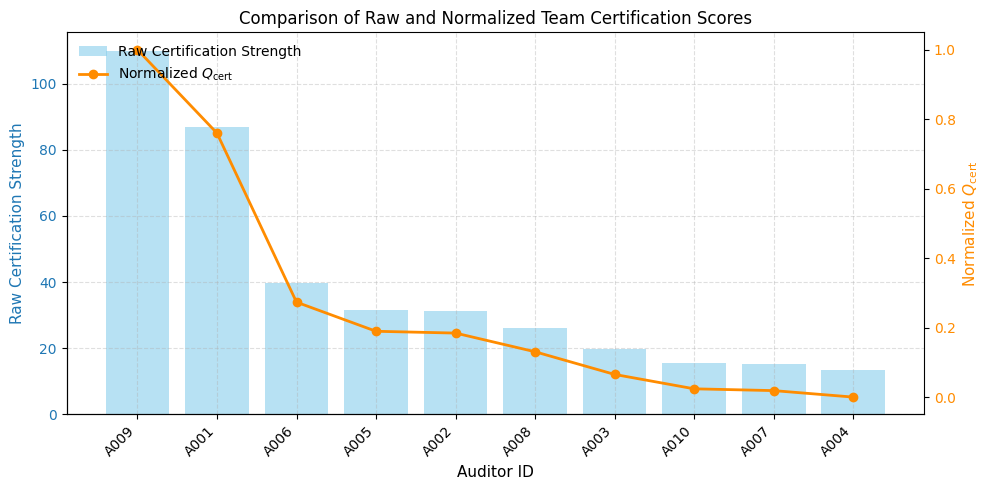

In [ ]:
import matplotlib.pyplot as plt

# Sort auditors by normalized score
Q_cert_sorted = Q_cert.sort_values("Q_cert", ascending=False).reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(10, 5))

# --- Left Y-axis: Raw Certification Strength ---
ax1.bar(
    Q_cert_sorted["auditor_id"],
    Q_cert_sorted["CertficateScore_raw"],
    color="skyblue",
    alpha=0.6,
    label="Raw Certification Strength",
    zorder=1
)

ax1.set_xlabel("Auditor ID", fontsize=11)
ax1.set_ylabel("Raw Certification Strength", color="tab:blue", fontsize=11)
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_xticklabels(Q_cert_sorted["auditor_id"], rotation=45, ha='right')

# --- Right Y-axis: Normalized Certification Score ---
ax2 = ax1.twinx()
ax2.plot(
    Q_cert_sorted["auditor_id"],
    Q_cert_sorted["Q_cert"],
    color="darkorange",
    marker="o",
    linewidth=2,
    label="Normalized $Q_{\\text{cert}}$",
    zorder=2
)

ax2.set_ylabel("Normalized $Q_{\\text{cert}}$", color="darkorange", fontsize=11)
ax2.tick_params(axis='y', labelcolor="darkorange")

# --- Style and Legend ---
plt.title("Comparison of Raw and Normalized Team Certification Scores", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.4)
plt.gca().spines[['top', 'right']].set_visible(False)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", frameon=False)

plt.tight_layout()
plt.show()


In [ ]:
# Rename for consistency with other score tables
Q_ret = Qret_df[["auditor_id", "Q_ret"]].copy()


In [ ]:
# ===================================
# STEP 8: Merge All Scores
# ===================================

# Make sure all necessary dataframes are available
dfs_to_merge = []

if 'Q_exp' in globals() and isinstance(Q_exp, pd.DataFrame):
    dfs_to_merge.append(Q_exp[['auditor_id', 'Q_exp']])
else:
    print("Warning: Q_exp DataFrame not found or is not a DataFrame.")

if 'Q_cert' in globals() and isinstance(Q_cert, pd.DataFrame):
     dfs_to_merge.append(Q_cert[['auditor_id', 'Q_cert']])
else:
    print("Warning: Q_cert DataFrame not found or is not a DataFrame.")


if 'Q_tools' in globals() and isinstance(Q_tools, pd.DataFrame):
    dfs_to_merge.append(Q_tools[['auditor_id', 'Q_tools']])
else:
    print("Warning: Q_tools DataFrame not found or is not a DataFrame.")


if 'Q_ret' in globals() and isinstance(Q_ret, pd.DataFrame):
     # Use Q_ret which contains the Q_ret column
     dfs_to_merge.append(Q_ret[['auditor_id', 'Q_ret']])
else:
    print("Warning: Q_ret DataFrame not found or is not a DataFrame.")


if 'Q_scope' in globals() and isinstance(Q_scope, pd.DataFrame):
     dfs_to_merge.append(Q_scope[['auditor_id', 'Q_scope']])
else:
    print("Warning: Q_scope DataFrame not found or is not a DataFrame.")


if 'Q_proj' in globals() and isinstance(Q_proj, pd.DataFrame):
     dfs_to_merge.append(Q_proj[['auditor_id', 'Q_proj']])
else:
    print("Warning: Q_proj DataFrame not found or is not a DataFrame.")


# Start with the base dataframe containing auditor_id and name
score_df = auditors_df[["auditor_id", "name"]].copy()

# Merge the available dataframes
for df in dfs_to_merge:
    score_df = score_df.merge(df, on="auditor_id", how="left")

# Fill any resulting NaN values with 0 (for auditors missing scores)
score_df = score_df.fillna(0)

# Display the merged dataframe
print("Merged Score DataFrame:")
display(score_df)

Merged Score DataFrame:


,auditor_id,name,Q_exp,Q_cert,Q_tools,Q_ret,Q_scope,Q_proj
0,A001,AAA Technologies Pvt Ltd,1.000000,0.759834,0.582,0.849276,0.400835,0.984318
1,A002,Bharat Electronics Limited,0.000000,0.184265,0.589,0.462345,0.000000,0.000000
2,A003,CyRAAC Services Private Limited,0.085808,0.065217,0.570,0.039178,0.813283,0.000000
3,A004,Madhya Pradesh State Electronics Development C...,0.082700,0.000000,0.514,0.346770,0.193813,0.000000
4,A005,Maverick Quality Advisory Services Private Lim...,0.567507,0.189441,0.419,0.088091,0.551006,0.301110
5,A006,RSM Astute Consulting Pvt. Ltd.,0.014675,0.273292,0.691,0.565450,0.186192,0.228676
6,A007,Mirox Cyber Security & Technology Pvt Ltd,0.087189,0.018634,0.230,0.000000,0.334179,0.000000
7,A008,AQM Technologies Pvt Ltd.,0.001727,0.130435,0.651,0.464738,0.193618,1.000000
8,A009,Centre for Development of Advanced Computing (...,0.262949,1.000000,0.753,1.000000,0.565801,0.801081
9,A010,Crossbow Labs LLP,0.048688,0.023810,0.594,0.165756,1.000000,0.000000


In [ ]:
# ===================================
# STEP 9: Entropy-Based Weight Calibration
# ===================================

X = score_df[["Q_exp", "Q_cert", "Q_tools", "Q_ret", "Q_scope", "Q_proj"]].to_numpy()
n, m = X.shape

# Step 1: Proportion matrix
P = X / X.sum(axis=0, keepdims=True)
P = np.nan_to_num(P)

# Step 2: Entropy
k = 1 / np.log(n)
E = -k * np.sum(P * np.log(P + 1e-12), axis=0)

# Step 3: Information utility
d = 1 - E
weights = d / np.sum(d)

weight_labels = ["α (exp)", "β (cert)", "γ (tools)", "δ (ret)", "ε (scope)", "ζ (proj)"]
weights_dict = dict(zip(weight_labels, weights))

print("=== Entropy-based Weights ===")
for k_, v in weights_dict.items():
    print(f"{k_}: {v:.3f}")


=== Entropy-based Weights ===
α (exp): 0.277
β (cert): 0.217
γ (tools): 0.012
δ (ret): 0.125
ε (scope): 0.090
ζ (proj): 0.279


In [ ]:
# ===================================
# STEP 10: Final CERTScore Computation
# ===================================

score_df["CERTScore"] = (
    weights[0]*score_df["Q_exp"] +
    weights[1]*score_df["Q_cert"] +
    weights[2]*score_df["Q_tools"] +
    weights[3]*score_df["Q_ret"] +
    weights[4]*score_df["Q_scope"] +
    weights[5]*score_df["Q_proj"]
)

# Rank auditors by CERTScore
score_df["Rank"] = score_df["CERTScore"].rank(ascending=False)

In [ ]:
# ===================================
# STEP 11: Display Final Results
# ===================================

score_df_sorted = score_df.sort_values(by="CERTScore", ascending=False)
score_df_sorted = score_df_sorted.round(3)

from google.colab import data_table
data_table.enable_dataframe_formatter()

score_df_sorted

,auditor_id,name,Q_exp,Q_cert,Q_tools,Q_ret,Q_scope,Q_proj,CERTScore,Rank
0,A001,AAA Technologies Pvt Ltd,1.000,0.760,0.582,0.849,0.401,0.984,0.866,1.0
8,A009,Centre for Development of Advanced Computing (...,0.263,1.000,0.753,1.000,0.566,0.801,0.698,2.0
7,A008,AQM Technologies Pvt Ltd.,0.002,0.130,0.651,0.465,0.194,1.000,0.391,3.0
4,A005,Maverick Quality Advisory Services Private Lim...,0.568,0.189,0.419,0.088,0.551,0.301,0.348,4.0
5,A006,RSM Astute Consulting Pvt. Ltd.,0.015,0.273,0.691,0.565,0.186,0.229,0.223,5.0
9,A010,Crossbow Labs LLP,0.049,0.024,0.594,0.166,1.000,0.000,0.136,6.0
2,A003,CyRAAC Services Private Limited,0.086,0.065,0.570,0.039,0.813,0.000,0.123,7.0
1,A002,Bharat Electronics Limited,0.000,0.184,0.589,0.462,0.000,0.000,0.105,8.0
3,A004,Madhya Pradesh State Electronics Development C...,0.083,0.000,0.514,0.347,0.194,0.000,0.090,9.0
6,A007,Mirox Cyber Security & Technology Pvt Ltd,0.087,0.019,0.230,0.000,0.334,0.000,0.061,10.0


In [ ]:
# ===================================
# STEP 11: Local Sensitivity of Top-Level Weights
# ===================================

import numpy as np
import pandas as pd

# 1) Save baseline weights, scores, and ranks
baseline_weights = weights.copy()  # entropy-based weights from your earlier cell

baseline_df = score_df[["auditor_id", "CERTScore"]].copy()
baseline_df["Rank_baseline"] = baseline_df["CERTScore"].rank(
    ascending=False, method="min"
)

# Helper: recompute CERTScore + ranks for a given weight vector
def compute_ranking_from_weights(w):
    tmp = score_df.copy()
    tmp["CERTScore_tmp"] = (
        w[0] * tmp["Q_exp"]
        + w[1] * tmp["Q_cert"]
        + w[2] * tmp["Q_tools"]
        + w[3] * tmp["Q_ret"]
        + w[4] * tmp["Q_scope"]
        + w[5] * tmp["Q_proj"]
    )
    tmp["Rank_tmp"] = tmp["CERTScore_tmp"].rank(
        ascending=False, method="min"
    )
    return tmp[["auditor_id", "CERTScore_tmp", "Rank_tmp"]]

# Helper: compute Spearman rank correlation
def spearman_corr(r1, r2):
    s1 = pd.Series(r1).astype(float)
    s2 = pd.Series(r2).astype(float)
    return s1.corr(s2, method="spearman")

dimension_labels = ["Q_exp", "Q_cert", "Q_tools", "Q_ret", "Q_scope", "Q_proj"]
results = []

for j, dim_name in enumerate(dimension_labels):
    for direction in [+0.10, -0.10]:  # ±10% perturbation
        w = baseline_weights.copy().astype(float)
        w[j] *= (1.0 + direction)
        w = w / w.sum()  # renormalize to sum to 1

        pert_df = compute_ranking_from_weights(w)

        merged = baseline_df.merge(pert_df, on="auditor_id")
        rho = spearman_corr(merged["Rank_baseline"], merged["Rank_tmp"])
        max_shift = (merged["Rank_baseline"] - merged["Rank_tmp"]).abs().max()

        results.append({
            "Dimension": dim_name,
            "Perturbation": f"{'+' if direction>0 else ''}{int(direction*100)}%",
            "Spearman_rho": round(rho, 3),
            "Max_rank_shift": int(max_shift)
        })

sensitivity_df = pd.DataFrame(results)

print("=== Local Sensitivity of CERTScore to Top-Level Weights (±10%) ===")
display(sensitivity_df)


=== Local Sensitivity of CERTScore to Top-Level Weights (±10%) ===


,Dimension,Perturbation,Spearman_rho,Max_rank_shift
0,Q_exp,+10%,1.0,0
1,Q_exp,-10%,1.0,0
2,Q_cert,+10%,1.0,0
3,Q_cert,-10%,1.0,0
4,Q_tools,+10%,1.0,0
5,Q_tools,-10%,1.0,0
6,Q_ret,+10%,1.0,0
7,Q_ret,-10%,1.0,0
8,Q_scope,+10%,1.0,0
9,Q_scope,-10%,1.0,0


In [ ]:
# ===================================
# STEP 12: Global Sensitivity via Monte Carlo Sampling
# ===================================

import numpy as np
import pandas as pd

# Reuse helper from previous cell:
# - compute_ranking_from_weights(...)
# And we assume 'baseline_df' and 'baseline_weights' already defined.

n_runs = 1000  # you can reduce to e.g. 200 if it is too slow

auditor_ids = score_df["auditor_id"].tolist()
rank_traces = {aid: [] for aid in auditor_ids}

for run in range(n_runs):
    # Sample random non-negative numbers and normalize (Dirichlet-like)
    w_raw = np.random.rand(6)
    w = w_raw / w_raw.sum()

    pert_df = compute_ranking_from_weights(w)

    for _, row in pert_df.iterrows():
        aid = row["auditor_id"]
        rank_traces[aid].append(row["Rank_tmp"])

# Summarize rank distribution for each auditor
summary_rows = []
for aid in auditor_ids:
    ranks = np.array(rank_traces[aid], dtype=float)
    mean_rank = ranks.mean()
    std_rank = ranks.std(ddof=0)
    top3_freq = np.mean(ranks <= 3)  # fraction of runs in which auditor is in top-3
    summary_rows.append({
        "auditor_id": aid,
        "Mean_rank": round(mean_rank, 2),
        "Rank_std": round(std_rank, 2),
        "Top3_frequency": round(top3_freq, 3)
    })

robustness_df = pd.DataFrame(summary_rows)

# Attach auditor names and baseline rank for readability
robustness_df = robustness_df.merge(
    auditors_df[["auditor_id", "name"]],
    on="auditor_id",
    how="left"
)

robustness_df = robustness_df.merge(
    baseline_df[["auditor_id", "Rank_baseline"]],
    on="auditor_id",
    how="left"
)

robustness_df = robustness_df.sort_values("Rank_baseline")

print(f"=== Global Robustness of Rankings over {n_runs} Random Weight Samples ===")
display(robustness_df)


=== Global Robustness of Rankings over 1000 Random Weight Samples ===


,auditor_id,Mean_rank,Rank_std,Top3_frequency,name,Rank_baseline
0,A001,1.34,0.48,0.999,AAA Technologies Pvt Ltd,1.0
8,A009,1.66,0.48,1.000,Centre for Development of Advanced Computing (...,2.0
7,A008,3.87,1.28,0.598,AQM Technologies Pvt Ltd.,3.0
4,A005,4.45,1.16,0.222,Maverick Quality Advisory Services Private Lim...,4.0
5,A006,5.09,1.19,0.066,RSM Astute Consulting Pvt. Ltd.,5.0
9,A010,5.37,1.42,0.114,Crossbow Labs LLP,6.0
2,A003,7.00,1.24,0.001,CyRAAC Services Private Limited,7.0
1,A002,7.85,1.27,0.000,Bharat Electronics Limited,8.0
3,A004,8.49,0.67,0.000,Madhya Pradesh State Electronics Development C...,9.0
6,A007,9.88,0.43,0.000,Mirox Cyber Security & Technology Pvt Ltd,10.0


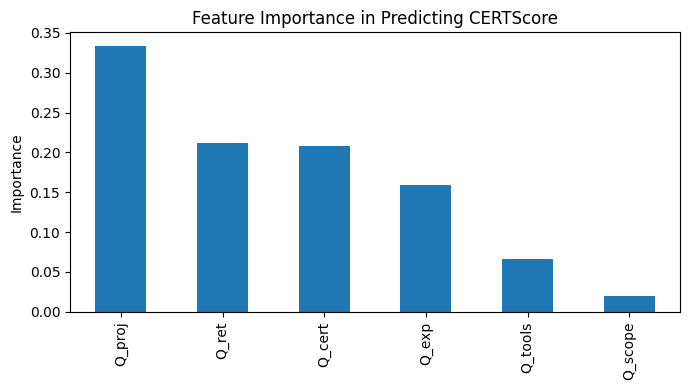

Feature Importance:
 Q_proj     0.334029
Q_ret      0.211228
Q_cert     0.208488
Q_exp      0.159271
Q_tools    0.066684
Q_scope    0.020300
dtype: float64

Cluster Assignments:
  auditor_id                                               name  Cluster
0       A001                           AAA Technologies Pvt Ltd        2
1       A002                         Bharat Electronics Limited        0
2       A003                    CyRAAC Services Private Limited        0
3       A004  Madhya Pradesh State Electronics Development C...        0
4       A005  Maverick Quality Advisory Services Private Lim...        0
5       A006                    RSM Astute Consulting Pvt. Ltd.        0
6       A007          Mirox Cyber Security & Technology Pvt Ltd        0
7       A008                          AQM Technologies Pvt Ltd.        0
8       A009  Centre for Development of Advanced Computing (...        1
9       A010                                  Crossbow Labs LLP        0


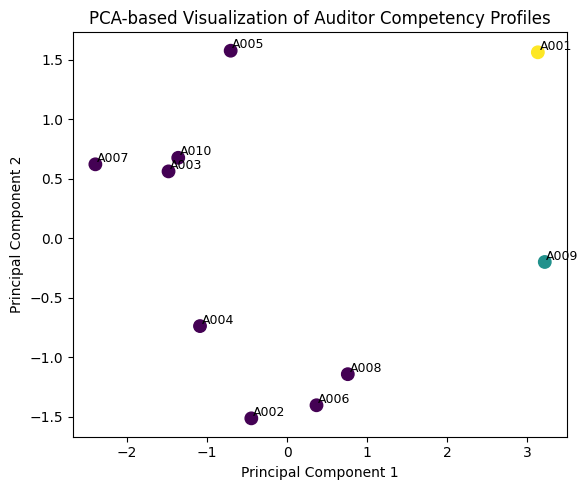

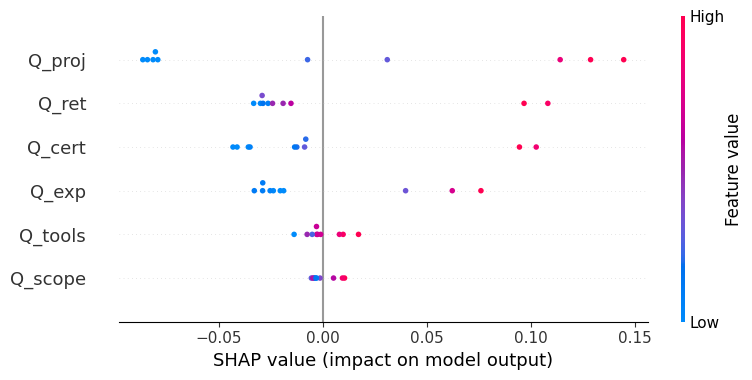

In [ ]:
# ============================================================
# CERT-In Auditor ML Representation using Pre-computed Results
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import shap

# ---------------------------------------------
# Step 1: Use your already computed score_df
# ---------------------------------------------
# Assumes score_df has columns:
# ['auditor_id','name','Q_exp','Q_cert','Q_tools','Q_ret','Q_scope','Q_proj','CERTScore','Rank']

X = score_df[['Q_exp','Q_cert','Q_tools','Q_ret','Q_scope','Q_proj']]
y = score_df['CERTScore']

# ---------------------------------------------
# Step 2: Regression Analysis (Random Forest)
# ---------------------------------------------
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(7,4))
importances.plot(kind='bar')
plt.title("Feature Importance in Predicting CERTScore")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

print("Feature Importance:\n", importances)

# ---------------------------------------------
# Step 3: Unsupervised Clustering (K-Means)
# ---------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
score_df['Cluster'] = kmeans.fit_predict(X_scaled)

print("\nCluster Assignments:")
print(score_df[['auditor_id','name','Cluster']])

# ---------------------------------------------
# Step 4: PCA Visualization
# ---------------------------------------------
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)
score_df['PC1'], score_df['PC2'] = reduced[:,0], reduced[:,1]

plt.figure(figsize=(6,5))
plt.scatter(score_df['PC1'], score_df['PC2'], c=score_df['Cluster'], s=80, cmap='viridis')
for i, name in enumerate(score_df['auditor_id']):
    plt.text(score_df['PC1'][i]+0.02, score_df['PC2'][i]+0.02, name, fontsize=9)
plt.title("PCA-based Visualization of Auditor Competency Profiles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()

# ---------------------------------------------
# Step 5: Explainability using SHAP
# ---------------------------------------------
explainer = shap.Explainer(rf, X)
shap_values = explainer(X)

# Summary plot (global feature influence)
shap.summary_plot(shap_values, X)

# Optional: individual auditor-level interpretation
# shap.plots.waterfall(shap_values[i])  # for any specific auditor i
